# Full ML Pipeline Example

## Loading Data and Exploratory Data Analysis

In [1]:
import pandas as pd
housing = pd.read_csv(r"../datasets/housing/housing.csv")
# housing = pd.read_csv(r"housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
# get a summary of df
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
# looking at object data
housing['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
# get summary of numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


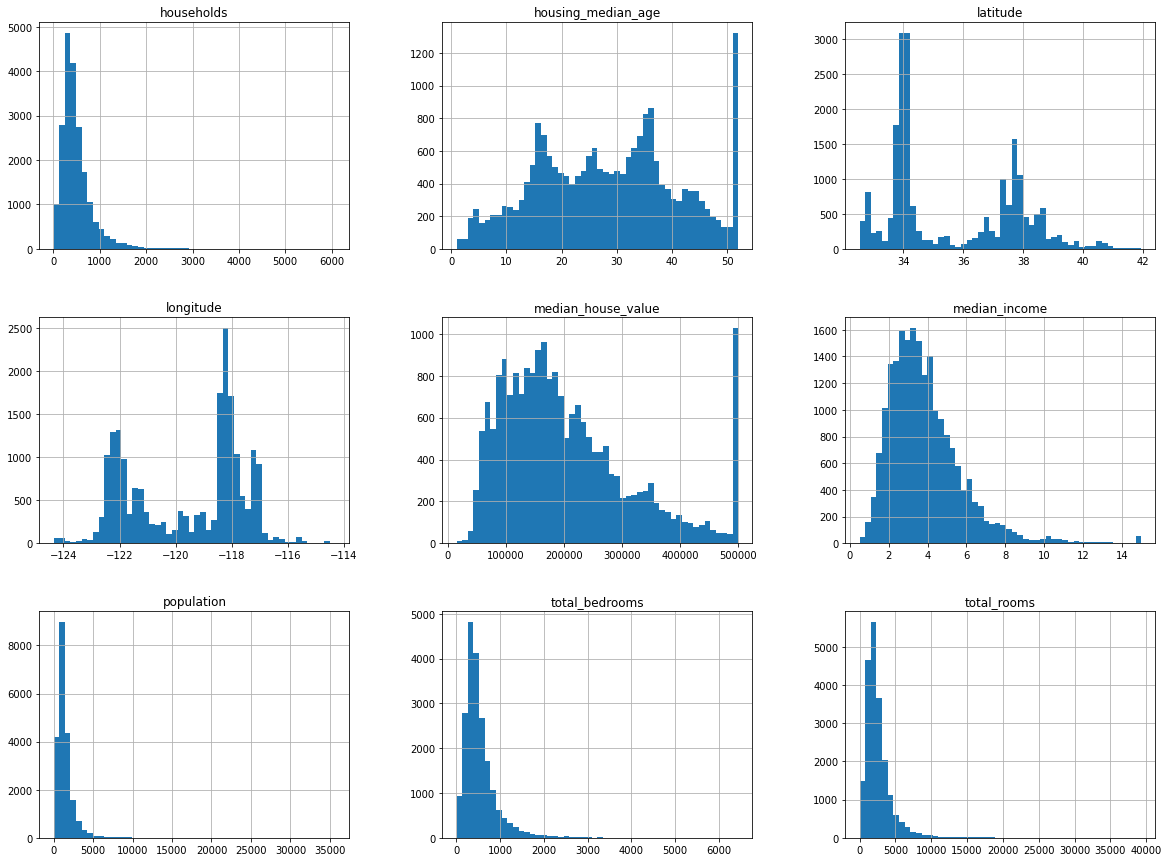

In [5]:
# only in a Jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

There are a few things you might notice in these histograms:

1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s out put) to see if this is a problem or not. If they tell you that they need precise pre dictions even beyond $500,000, then you have two options:

    a. Collect proper labels for the districts whose labels were capped.

    b. Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

3. These attributes have very different scales. We will discuss this later, when we explore feature scaling.

4. Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### Creating a Test Set

In [0]:
# utility function to split data
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

In [0]:
# to counter the above problem we use
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. If the people running the survey used purely random sampling, there would be about a 12% chance of sampling a skewed test set hat was either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

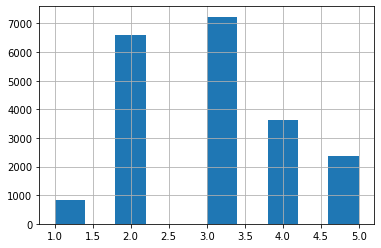

In [9]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)
housing["income_cat"].hist()

In [10]:
# stratified sampling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
strat_test_set["income_cat"].value_counts() / len(strat_test_set)    

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [0]:
# for now, remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Visualising the Data

In [0]:
# create a copy of train data to play with
housing = strat_train_set.copy()

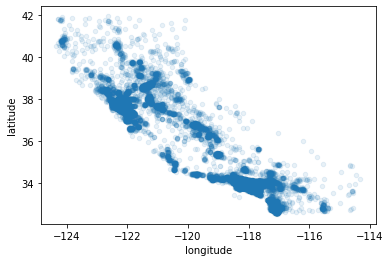

In [13]:
# Visualizing Geographical Data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)  # alpha to get density

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

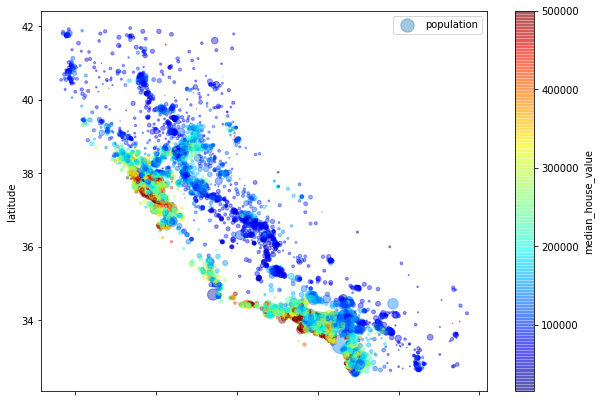

In [14]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", 
    figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

### Checking Correlations
Check [this](https://en.wikipedia.org/wiki/Correlation_and_dependence) for some information on correlation.

In [15]:
corr_matrix = housing.corr()
# corr_matrix["median_house_value"].sort_values(ascending=False)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc220293748>,
      dtype=object)

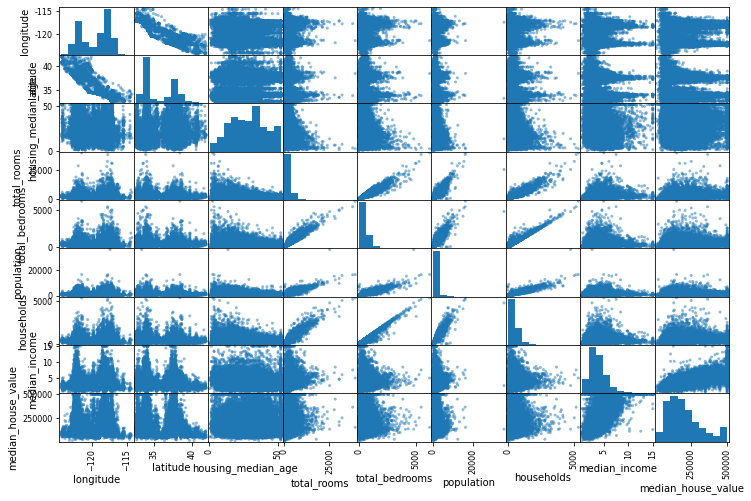

In [16]:
# plotting correlation of every numerical attribute with evry other numericcal attribute
from pandas.plotting import scatter_matrix

numeric_features = housing.select_dtypes(include=['int64', 'float64']).columns
scatter_matrix(housing[numeric_features], figsize=(12, 8))

The main diagonal (top left to bottom right) would be full of straight lines if pandas plotted each variable against itself, which would not be very useful. So instead pandas displays a histogram of each attribute (other options are available; see the pandas documentation for more details).

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

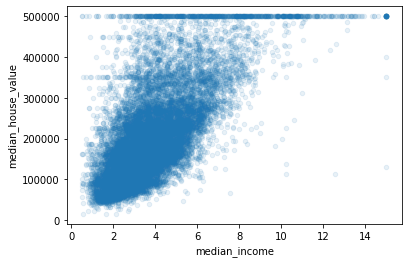

In [17]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at \$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \$450,000, another around \$350,000, perhaps one around \$280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations
One last thing you may want to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [18]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

# checking new correlation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

## Prepare the Data for Machine Learning Algorithms
It’s time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose, for several good reasons:
* This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).
* You will gradually build a library of transformation functions that you can reuse in future projects.
* You can use these functions in your live system to transform the new data before feeding it to your algorithms.
* This will make it possible for you to easily try various transformations and see which combination of transformations works best.

In [0]:
# reverting to clean training data
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning
We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

1. Get rid of the corresponding districts. 
```
housing.dropna(subset=["total_bedrooms"])
```
2. Get rid of the whole attribute.
```
housing.drop("total_bedrooms", axis=1)
```
3. Set the values to some value (zero, the mean, the median, etc.).
```
housing["total_bedrooms"].fillna(housing["total_bedrooms"].median(), inplace=True)
```

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# remove categorical attr
housing_num = housing.drop("ocean_proximity", axis=1)
# fit imputer
imputer.fit(housing_num)
# check statistics of imputer
print("imputed values")
print(imputer.statistics_)
# check median values of numerical attrs
print("median values")
print(housing_num.median().values)

imputed values
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
median values
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [21]:
# use imputer to trnsform the training data
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Textual and Categorical Attributes

In [22]:
# print Head of categorical attributes
housing_cat = housing.select_dtypes(include=['object'])
housing_cat.head(10)


,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [23]:
# Converting categorical data to numbers
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:5])
print(housing_cat[:5])
print(ordinal_encoder.categories_)

[[0.]
 [0.]
 [4.]
 [1.]
 [0.]]
      ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obvi‐ ously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the cate‐ gory is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the cate‐ gory is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:


In [24]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [25]:
# printing top few columns
print(housing_cat_1hot.toarray()[:5])
print(cat_encoder.categories_)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn func‐ tionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inher‐ itance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().

You can get the last one for free by simply adding TransformerMixin as a base class. If you add BaseEstimator as a base class (and avoid *args and **kargs in your con‐ structor), you will also get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.

For example, here is a small transformer class that adds the combined attributes we discussed earlier:


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
       
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [27]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs[:5]

array([[-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
        '<1H OCEAN', 4.625368731563422, 2.094395280235988],
       [-121.93, 37.05, 14.0, 679.0, 108.0, 306.0, 113.0, 6.4214,
        '<1H OCEAN', 6.008849557522124, 2.7079646017699117],
       [-117.2, 32.77, 31.0, 1952.0, 471.0, 936.0, 462.0, 2.8621,
        'NEAR OCEAN', 4.225108225108225, 2.0259740259740258],
       [-119.61, 36.31, 25.0, 1847.0, 371.0, 1460.0, 353.0, 1.8839,
        'INLAND', 5.232294617563739, 4.135977337110481],
       [-118.59, 34.23, 17.0, 6592.0, 1525.0, 4459.0, 1463.0, 3.0347,
        '<1H OCEAN', 4.50580997949419, 3.047846889952153]], dtype=object)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperpara‐ meter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

### Feature Scaling
* [Standard Scalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* [MinMax Scalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

### Transformation Pipeline
Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline(
    [
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ]
)
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr[:2]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902]])

So far, we have handled the categorical columns and the numerical columns sepa‐ rately. It would be more convenient to have a single transformer able to handle all col‐ umns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news is that it works great with pandas DataFrames. Let’s use it to apply all the transforma‐ tions to the housing data:

In [29]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ]
)

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[:2]


array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

## Selecting and training a model

In [30]:
# training and eval on train set
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))


Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error() function

In [31]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848923


This is better than nothing, but clearly not a great score: most districts’ median_hous ing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data. The code should look familiar by now:

In [32]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [33]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

### Better Evaluation Using Cross-Validation
The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a neg‐ ative value), which is why the preceding code computes -scores before calculating the square root.

In [35]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


Scores: [68566.1369861  65708.7360406  71140.70317171 68390.9731597
 72372.57284009 75081.80218631 70825.87363253 70735.53150894
 76532.46974677 71225.7392875 ]
Mean: 71058.05385602477
Standard deviation: 3000.3131166837566


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to per‐ form worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,093, generally ±2,408. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [36]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let’s try one last model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further. 

In [37]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [49206.19773022 47769.03012396 49952.95475562 52232.53366618
 49766.51609118 53946.84443222 48782.21652487 48331.5036633
 52877.66558533 50240.42723312]
Mean: 50310.58898059955
Standard deviation: 1945.9406493876054


Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. Before you dive much deeper into Random Forests, however, you should try out many other models from various categories of Machine Learning algorithms (e.g., several Support Vector Machines with different kernels, and possibly a neural net‐ work), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

## Fine-Tune Your Model


### Grid Search
One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor: 


In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first dict (don’t worry about what these hyperparameters mean for now; they will be explained in Chapter 7), then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, but this time with the bootstrap hyperparameter set to False instead of True (which is the default value for this hyperparameter).

The grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model 5 times (since we are using fivefold cross validation). In other words, all in all, there will be 18 × 5 = 90 rounds of training! It may take quite a long time, but when it is done you can get the best com‐ bination of parameters like this: 

In [39]:
# print best parameters
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [40]:
# print best estimators
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best estimator using crossvalidation, it retrains it on the whole training set. This is usually a good idea, since feeding it more data will likely improve its performance.

In [41]:
# evaluation scores 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


63846.49598912045 {'max_features': 2, 'n_estimators': 3}
55515.3314948442 {'max_features': 2, 'n_estimators': 10}
52567.00351238722 {'max_features': 2, 'n_estimators': 30}
60283.196292734145 {'max_features': 4, 'n_estimators': 3}
52803.135609017605 {'max_features': 4, 'n_estimators': 10}
50748.833872038034 {'max_features': 4, 'n_estimators': 30}
60036.810755306724 {'max_features': 6, 'n_estimators': 3}
52125.193042039755 {'max_features': 6, 'n_estimators': 10}
50218.53720043253 {'max_features': 6, 'n_estimators': 30}
58942.94616806686 {'max_features': 8, 'n_estimators': 3}
51837.3761840818 {'max_features': 8, 'n_estimators': 10}
50004.36628889995 {'max_features': 8, 'n_estimators': 30}
62419.75990901835 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54946.47995058286 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59505.13777038305 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52676.631240890754 {'bootstrap': False, 'max_features': 3, 'n_estimators'

### Randomized Search
The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combi‐ nations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
* If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few val‐ ues per hyperparameter with the grid search approach).
* Simply by setting the number of iterations, you have more control over the com‐ puting budget you want to allocate to hyperparameter search.

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

### Analyze the Best Models and Their Errors
You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [43]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.07932490e-02, 6.50661968e-02, 4.28352229e-02, 1.56140961e-02,
       1.47385578e-02, 1.48028553e-02, 1.40999213e-02, 3.72486359e-01,
       4.32648288e-02, 1.11709957e-01, 7.57616028e-02, 1.14917668e-02,
       1.40275377e-01, 4.80708332e-05, 2.85373999e-03, 4.15819883e-03])

In [44]:
# printing feature importance along with their name
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3724863594318218, 'median_income'),
 (0.14027537656624361, 'INLAND'),
 (0.1117099568204443, 'pop_per_hhold'),
 (0.07576160282351066, 'bedrooms_per_room'),
 (0.07079324901650269, 'longitude'),
 (0.06506619684845921, 'latitude'),
 (0.0432648287518701, 'rooms_per_hhold'),
 (0.04283522285989616, 'housing_median_age'),
 (0.015614096097949531, 'total_rooms'),
 (0.014802855267686578, 'population'),
 (0.01473855781054347, 'total_bedrooms'),
 (0.014099921264665194, 'households'),
 (0.01149176678590136, '<1H OCEAN'),
 (0.004158198829486877, 'NEAR OCEAN'),
 (0.0028537399917945294, 'NEAR BAY'),
 (4.8070833223941895e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.)

### Evaluating Final Model

In [45]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_mse, final_rmse)

2268838244.816146 47632.323529470465


In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model cur‐ rently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval()

In [46]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(
    confidence, len(squared_errors) - 1, 
    loc=squared_errors.mean(), 
    scale=stats.sem(squared_errors)
))

array([45699.69971132, 49489.53359981])

If you did a lot of hyperparameter tuning, the performance will usually be slightly
worse than what you measured using cross-validation (because your system ends up
fine-tuned to perform well on the validation data and will likely not perform as well
on unknown datasets). It is not the case in this example, but when this happens you
must resist the temptation to tweak the hyperparameters to make the numbers look
good on the test set; the improvements would be unlikely to generalize to new data.

# Extra 

In [47]:
# Trying out SVM
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)

print(grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   9.2s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   9.1s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.2s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.4s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 60.8min finished


70363.84006944533
{'C': 30000.0, 'kernel': 'linear'}


In [48]:
# trying RandomizedSearchCV with SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)

print(rnd_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.5s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  17.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  18.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  18.1s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 88.9min finished


54767.960710084146
{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}


In [49]:
# Saving rnd_search 
import joblib
joblib.dump(rnd_search, 'rnd_search.pkl')
loaded_rnd_search = joblib.load('rnd_search.pkl')
print(loaded_rnd_search.best_params_)

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}


In [51]:
# view crossvalidation results
pd.DataFrame(loaded_rnd_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.660876,0.063245,0.701298,0.012481,629.782,3.01012,linear,"{'C': 629.782329591372, 'gamma': 3.01012143091...",-4.598499e+09,-5.375914e+09,-5.103090e+09,-4.668777e+09,-5.096316e+09,-4.968519e+09,2.922918e+08,27
1,16.528844,0.296571,1.737921,0.013157,26290.2,0.908447,rbf,"{'C': 26290.206464300216, 'gamma': 0.908446969...",-3.957690e+09,-4.488056e+09,-4.368914e+09,-4.123394e+09,-4.285865e+09,-4.244784e+09,1.862448e+08,9
2,13.755374,0.051519,1.748755,0.010750,84.1411,0.0598388,rbf,"{'C': 84.14107900575871, 'gamma': 0.0598387686...",-9.497569e+09,-1.005819e+10,-1.036801e+10,-1.014761e+10,-1.022230e+10,-1.005874e+10,2.983999e+08,39
3,8.587712,0.097429,0.697921,0.006891,432.379,0.154162,linear,"{'C': 432.37884813148855, 'gamma': 0.154161967...",-4.613423e+09,-5.365650e+09,-5.114248e+09,-4.679945e+09,-5.130255e+09,-4.980704e+09,2.876575e+08,28
4,13.844306,0.044070,1.736593,0.004964,24.1751,3.50356,rbf,"{'C': 24.17508294611391, 'gamma': 3.5035574751...",-1.338195e+10,-1.413118e+10,-1.445876e+10,-1.436101e+10,-1.428058e+10,-1.412270e+10,3.855989e+08,50
